<a href="https://www.kaggle.com/code/giuliobenedetti/imagenet-reproducing-convnets?scriptVersionId=157199567" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

In this notebook, we aim to reproduce the VGG convolutional neural networks introduced by [_Simonyan & Zisserman 2015_](https://arxiv.org/pdf/1409.1556v6.pdf). In other words, we will design an analogous model on TensorFlow, train it with the data from the [ImageNet Object Classification Challenge](https://www.kaggle.com/competitions/imagenet-object-localization-challenge) and ultimately benchmark its performance with the original model. Further information is available in the [related repository](https://github.com/irenebernardi/VGG-16-replication/tree/main) for the current project.

# Environment Setup

First off, we import the necessary dependencies. Importantly, the custom functions to preprocess data and design model components were defined in a separate utility script available at [Utilities for VGG](https://www.kaggle.com/code/giuliobenedetti/utilities-for-vgg?scriptVersionId=157103969).

In [1]:
# Import packages

# Data analysis
import numpy as np
import pandas as pd

# File management
import os
import shutil

# Image visualisation
import matplotlib.pyplot as plt

# Neural network
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Custom utilities
import utilities_for_vgg as vggutils

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

Due to the large size of the data and the great computational demand, a [Tensor Processing Unit](https://www.kaggle.com/docs/tpu) (TPU) provided by Kaggle was used to execute this notebook. Here, we set up the TPU strategy for highly efficient execution.

In [2]:
# If TPU is available
try:
    # Detect TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())

except:
    tpu = None
    

# If TPU is defined
if tpu:
    # Initialise TPU
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # Instantiate a TPU distribution strategy
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

else:
    # Or instanstiate available strategy
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2023-12-31 11:40:35.270342: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-31 11:40:35.270471: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-31 11:40:35.270565: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-31 11:40:35.270634: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-31 11:40:35.270706: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-31 11:40:35.270889: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-31 11:40:35.270991: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


As a last step to setup our environment, we defined the constants that will be used to preprocess data and design model architectures. A batch size of 256 was fixed to agree with the original training strategy, whereas the number of epochs was changed from the original 74 to 10 due to training issues explained later.

In [3]:
# Define constants

# Set seed for reproducibility
SEED = 123
# Set batch size for mini-batch gradient descent
BATCH_SIZE = 32 * strategy.num_replicas_in_sync
# Set number of epochs to train model
EPOCH_NUM = 15

# Set kernel size for Conv2D layers
KERNEL_SIZE = 3
# Set padding mode for Conv2D layers
PAD_MODE = "same"
# Set activation function for Conv2D layers
ACTIVATION = "relu"

# Set pool size for MaxPool2D layers
POOL_SIZE = 2
# Set strides for MaxPool2D layers
POOL_STRIDES = 2

# Data Preprocessing

Due to computational limitations, we restricted the train set to classes starting with `n01`, which corresponds to about 170000 images or roughly 11% of the total train set.

In [4]:
# Store paths to base, train set and subset dirs
base_dir = "/kaggle/input/imagenet-object-localization-challenge/"
train_dir = base_dir + "ILSVRC/Data/CLS-LOC/train/"
devel_dir = "/kaggle/working/devel/"

# Fetch train set
raw_train_ds = tf.data.Dataset.list_files(train_dir + "n01*/*.JPEG", shuffle=False)

# Find size of train set
train_size = tf.data.experimental.cardinality(raw_train_ds).numpy()

# Shuffle train set
raw_train_ds = raw_train_ds.shuffle(train_size, reshuffle_each_iteration=False, seed=SEED)

print(f"Size of train set: {train_size}")

Size of train set: 164467


The class names were derived from the names of the training image directories. Both the train and the devel subsets included 128 classes as opposed to the original 1000 classes.

In [5]:
# Find class names from dir names
class_names = np.array(sorted([dir for dir in os.listdir(train_dir) if dir.startswith("n01")]))

# Set number of classes
CLASS_NUM = len(class_names)

print(class_names[:10])

['n01440764' 'n01443537' 'n01484850' 'n01491361' 'n01494475' 'n01496331'
 'n01498041' 'n01514668' 'n01514859' 'n01518878']


The class to which the devel images belong was obtained from the `LOC_val_solution` file. In total, the devel set contained 6350 images.

In [6]:
# Import devel labels
devel_df = pd.read_csv(base_dir + "LOC_val_solution.csv")

# Select devel images belonging to subset of classes
keep = devel_df["PredictionString"].str.startswith("n01")
devel_df = devel_df[keep]

# Replace prediction string with only class name
devel_df["PredictionString"] = devel_df["PredictionString"].str.split(expand=True)[0]
devel_df["ImageId"] = base_dir + "ILSVRC/Data/CLS-LOC/val/" + devel_df["ImageId"] + ".JPEG"

# Sort and polish dataframe
devel_df.sort_values(by=["ImageId"], inplace=True)
devel_df.index = range(len(devel_df))

In [7]:
# Create devel dir if it doesn't exists
if not os.path.exists(devel_dir):
    os.makedirs(devel_dir)

# Create class subdirs if they don't exist
for class_name in class_names:
    if not os.path.exists(devel_dir + class_name):
        os.makedirs(devel_dir + class_name)
    
# For every file in devel set
for index, row in devel_df.iterrows():
    
    # Define origin path
    origin = row["ImageId"]
    # Define class name
    class_name = row["PredictionString"] + "/"
    # Fetch file name
    file_name = origin.split("/")[-1]
    # Define destination path
    destination = devel_dir + class_name + file_name
    
    # Copy devel file to devel dir if it doesn't exist
    if not os.path.exists(destination):
        shutil.copy(origin, destination)

In [8]:
# Fetch devel set
raw_devel_ds = tf.data.Dataset.list_files(devel_dir + "n01*/*.JPEG", shuffle=False)

# Find size of devel set
devel_size = tf.data.experimental.cardinality(raw_devel_ds).numpy()

# Shuffle devel set
raw_devel_ds = raw_train_ds.shuffle(devel_size, reshuffle_each_iteration=False, seed=SEED)

print(f"Size of devel set: {devel_size}")

Size of devel set: 6350


Below we visualise how the preprocessing function changes a sample image by comparing the original image with its preprocessed version.

Class: 11


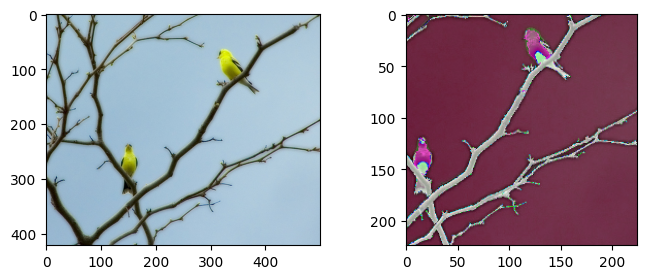

In [9]:
# Set path of original image
file_path = devel_dir + "n01531178/ILSVRC2012_val_00025535.JPEG"

# Preprocess sample image
image, label = vggutils.process_path(file_path, class_names)

# Store input shape for model design
input_shape = image.shape

# Plot original and preprocessed image
fig, axes = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(8)

axes[0].imshow(plt.imread(file_path))
axes[1].imshow(image)
print(f"Class: {label.numpy()}")

In principle, train and devel images were preprocessed in the same way.  They were first normalised by subtracting the mean RGB value of the entire ImageNet dataset, then rescaled by a factor S equal to 256, and finally cropped randomly to a square shape of (228, 228). In addition, the train images were flipped and enriched in colour contrast to augment the data.

In [10]:
# Preprocess train set
train_ds = raw_train_ds.map(
    lambda path: vggutils.process_path(path, class_names),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Preprocess devel set
devel_ds = raw_devel_ds.map(
    lambda path: vggutils.process_path(path, class_names, max_delta=0),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Show example
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  20


Then, both the train and test sets are processed for optimal performance by caching, prefetching and splitting them into batches.

In [11]:
# Improve train set performance
train_ds = train_ds \
    .cache() \
    .shuffle(buffer_size=1000, seed=SEED) \
    .batch(BATCH_SIZE) \
    .prefetch(buffer_size=tf.data.AUTOTUNE)

# Improve devel set performance
devel_ds = devel_ds \
    .batch(BATCH_SIZE) \
    .cache() \
    .prefetch(buffer_size=tf.data.AUTOTUNE)

The train images below were successfully preprocessed and shuffled. Thus, they appear in normalised colour and belong to various classes.

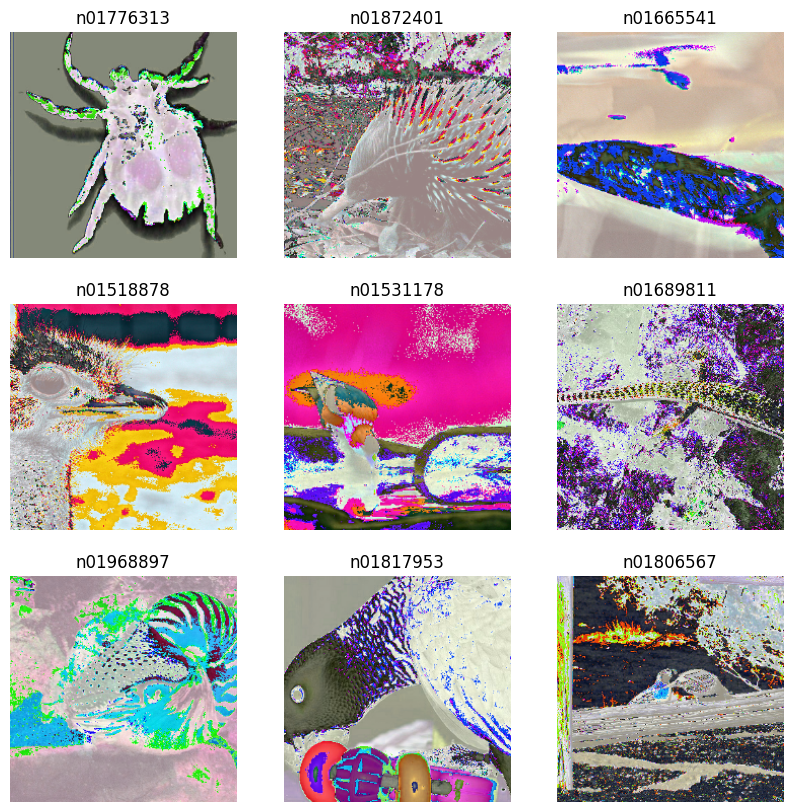

In [12]:
# Extract a sample of images from the first batch
image_batch, label_batch = next(iter(train_ds))

# Plot a sample of images from the first batch
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

# Model Design

In general, the model architecture resembles the model from the paper pretty well, even though some details may still be missing.

In [13]:
# Set up model within scope of tpu strategy
with strategy.scope():
    
    # Make environment more reproducible
    vggutils.reproduce_environment(random_state=SEED)
    
    # Build model
    model = vggutils.design_vgg11(
        class_num=CLASS_NUM,
        input_shape=input_shape,
        kernel_size=KERNEL_SIZE,
        padding=PAD_MODE,
        activation=ACTIVATION,
        pool_size=POOL_SIZE,
        strides=POOL_STRIDES
    )
    
    # Define optimiser
    sgd_optimiser = vggutils.create_optimiser()
    
    # Compile model
    model.compile(
        optimizer = sgd_optimiser,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["sparse_categorical_accuracy"]
    )

2023-12-31 11:41:59.198903: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-31 11:41:59.199129: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


To test that the model works, we train it for a few epochs. Ideally, we will train the model on the full dataset when once it resembles the model from the paper in terms of parameter number. 

In [14]:
# Update learning rate
lr_decay = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    mode="min",
    min_delta=1e-4,
    min_lr=1e-5
)

# Stop early
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    start_from_epoch=5
)

# Train model
history = model.fit(
    train_ds,
    validation_data=devel_ds,
    epochs=EPOCH_NUM,
    batch_size=BATCH_SIZE,
    verbose=False,
    callbacks=[lr_decay, early_stopping]
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}, Devel loss: {history_df['val_loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['sparse_categorical_accuracy'].iloc[-1]:.3f}, Devel accuracy: {history_df['val_sparse_categorical_accuracy'].iloc[-1]:.3f}")

2023-12-31 11:42:05.001537: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-31 11:42:05.018582: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-31 11:42:05.036131: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-31 11:42:05.053261: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-31 11:42:05.070144: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-31 11:42:05.086951: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-31 11:42:05.106731: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

Train loss: 1.485, Devel loss: 2.245
Train accuracy: 0.591, Devel accuracy: 0.456


The model contains 128778627 trainable parameters, which aligns pretty well with the 33 million in the paper.

However, our model differs from the original in that weights were initialised from a uniform glorot distribution and not from a normal distribution as described in the paper. This variation was chosen because custom initialisation would cause the loss to become a nan value during training. Such issue was likely due to a vanishing gradient and could be solved by defining a custom loss function with a small positive noise (epsilon), so that zero operations cannot occur.

<Axes: title={'center': 'Accuracy'}>

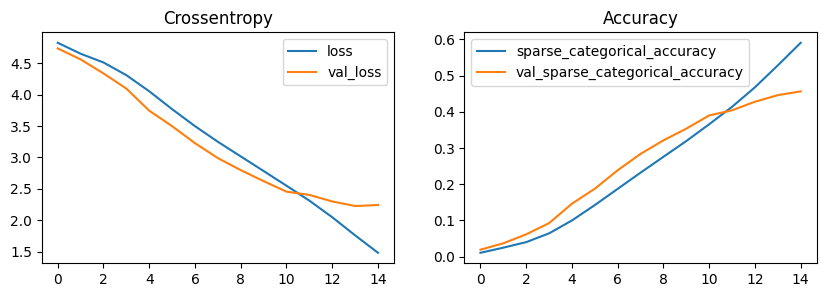

In [15]:
fig, axes = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(10)

# Visualise performance
history_df.loc[:, ["loss", "val_loss"]].plot(title="Crossentropy", ax=axes[0])
history_df.loc[:, ["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot(title="Accuracy", ax=axes[1])

VGG11 achieved an accuracy of about 45% on the devel set after 15 epochs. Unexpectedly, the model started overfitting much earlier than the original model, which was trained for 74 epochs according to the paper. Such divergence might be due to the smaller train set used in the current replication.

# Transfer Learning

The next step involved building deeper architectures by:
1. extracting first four convolutional layers and classification head from VGG11,
2. interlaying them with untrained convolutional layers and
3. training and validating the resulting model on the data

By transferring the learnt weights from the base model, we can build more complex and deeper architectures without too much computational burden. In particular, here we aim to reproduce the following three models from _Simonyan & Zisserman 2015_:
- VGG13 (13-layer ConvNet)
- VGG16 (16-layer ConvNet)
- VGG19 (19-layer ConvNet)

In the following cell, we store the VGG11 in a keras file that will be used to transfer the weights to the deeper architectures.

In [16]:
# Define model file
vgg11_file = f"/kaggle/working/{CLASS_NUM}class_vgg11.keras"

# Save model into file for replication purposes
model.save(vgg11_file)

## VGG13

Here, we built, trained and validated a 13-layer architecture based on VGG13. Weights for four convolutional layers and the three dense layers in the classification head were transferred from the pre-trained VGG11 model developed above.

In [17]:
# Set up model within scope of tpu strategy
with strategy.scope():
    
    # Make environment more reproducible
    vggutils.reproduce_environment(random_state=SEED)
    
    # Build model
    model = vggutils.design_vgg13(
        model_file=vgg11_file,
        kernel_size=KERNEL_SIZE,
        padding=PAD_MODE,
        activation=ACTIVATION,
        pool_size=POOL_SIZE,
        strides=POOL_STRIDES
    )
    
    # Define optimiser
    sgd_optimiser = vggutils.create_optimiser()
    
    # Compile model
    model.compile(
        optimizer = sgd_optimiser,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["sparse_categorical_accuracy"]
    )

In [18]:
# Update learning rate
lr_decay = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    min_delta=1e-4,
    min_lr=1e-5
)

# Stop early
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    start_from_epoch=5
)

# Train model
history = model.fit(
    train_ds,
    validation_data=devel_ds,
    epochs=EPOCH_NUM - 5,
    batch_size=BATCH_SIZE,
    verbose=False,
    callbacks=[lr_decay, early_stopping]
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}, Devel loss: {history_df['val_loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['sparse_categorical_accuracy'].iloc[-1]:.3f}, Devel accuracy: {history_df['val_sparse_categorical_accuracy'].iloc[-1]:.3f}")

2023-12-31 12:23:44.111939: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-12-31 12:26:00.886723: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


Train loss: 0.401, Devel loss: 2.397
Train accuracy: 0.877, Devel accuracy: 0.514


<Axes: title={'center': 'Accuracy'}>

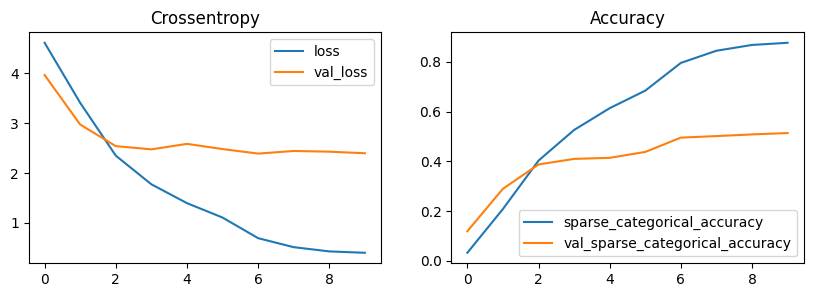

In [19]:
fig, axes = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(10)

# Visualise performance
history_df.loc[:, ["loss", "val_loss"]].plot(title="Crossentropy", ax=axes[0])
history_df.loc[:, ["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot(title="Accuracy", ax=axes[1])

In [20]:
# Define model file
vgg13_file = f"/kaggle/working/{CLASS_NUM}class_vgg13.keras"

# Save model into file for replication purposes
model.save(vgg13_file)

## VGG16

Here, we built, trained and validated a 16-layer architecture based on VGG16. Weights for four convolutional layers and the three dense layers in the classification head were transferred from the pre-trained VGG11 model developed above.

In [21]:
# Set up model within scope of tpu strategy
with strategy.scope():
    
    # Make environment more reproducible
    vggutils.reproduce_environment(random_state=SEED)
    
    # Build model
    model = vggutils.design_vgg16(
        model_file=vgg11_file,
        kernel_size=KERNEL_SIZE,
        padding=PAD_MODE,
        activation=ACTIVATION,
        pool_size=POOL_SIZE,
        strides=POOL_STRIDES
    )
    
    # Define optimiser
    sgd_optimiser = vggutils.create_optimiser()
    
    # Compile model
    model.compile(
        optimizer = sgd_optimiser,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["sparse_categorical_accuracy"]
    )

In [22]:
# Update learning rate
lr_decay = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    mode="min",
    min_delta=1e-4,
    min_lr=1e-5
)

# Stop early
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    start_from_epoch=5
)

# Train model
history = model.fit(
    train_ds,
    validation_data=devel_ds,
    epochs=EPOCH_NUM - 5,
    batch_size=BATCH_SIZE,
    verbose=False,
    callbacks=[lr_decay, early_stopping]
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}, Devel loss: {history_df['val_loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['sparse_categorical_accuracy'].iloc[-1]:.3f}, Devel accuracy: {history_df['val_sparse_categorical_accuracy'].iloc[-1]:.3f}")

2023-12-31 12:53:51.736609: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-12-31 12:56:23.100376: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


Train loss: 0.428, Devel loss: 2.543
Train accuracy: 0.869, Devel accuracy: 0.502


<Axes: title={'center': 'Accuracy'}>

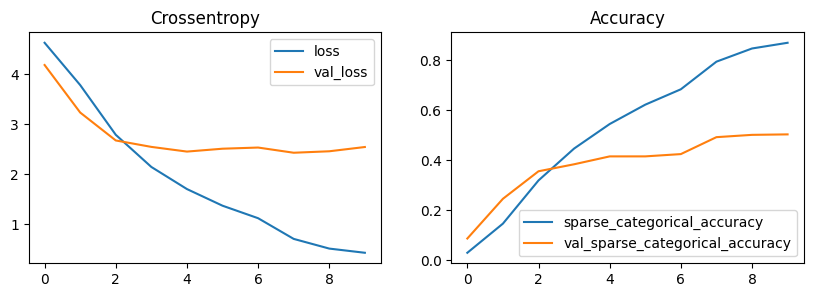

In [23]:
fig, axes = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(10)

# Visualise performance
history_df.loc[:, ["loss", "val_loss"]].plot(title="Crossentropy", ax=axes[0])
history_df.loc[:, ["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot(title="Accuracy", ax=axes[1])

In [24]:
# Define model file
vgg16_file = f"/kaggle/working/{CLASS_NUM}class_vgg16.keras"

# Save model into file for replication purposes
model.save(vgg16_file)

## VGG19

Here, we built, trained and validated a 19-layer architecture based on VGG19. Weights for four convolutional layers and the three dense layers in the classification head were transferred from the pre-trained VGG11 model developed above.

In [25]:
# Set up model within scope of tpu strategy
with strategy.scope():
    
    # Make environment more reproducible
    vggutils.reproduce_environment(random_state=SEED)
    
    # Build model
    model = vggutils.design_vgg19(
        model_file=vgg11_file,
        kernel_size=KERNEL_SIZE,
        padding=PAD_MODE,
        activation=ACTIVATION,
        pool_size=POOL_SIZE,
        strides=POOL_STRIDES
    )
    
    # Define optimiser
    sgd_optimiser = vggutils.create_optimiser()
    
    # Compile model
    model.compile(
        optimizer = sgd_optimiser,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["sparse_categorical_accuracy"]
    )

In [26]:
# Update learning rate
lr_decay = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    mode="min",
    min_delta=1e-4,
    min_lr=1e-5
)

# Stop early
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    start_from_epoch=5
)

# Train model
history = model.fit(
    train_ds,
    validation_data=devel_ds,
    epochs=EPOCH_NUM - 5,
    batch_size=BATCH_SIZE,
    verbose=False,
    callbacks=[lr_decay, early_stopping]
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}, Devel loss: {history_df['val_loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['sparse_categorical_accuracy'].iloc[-1]:.3f}, Devel accuracy: {history_df['val_sparse_categorical_accuracy'].iloc[-1]:.3f}")

2023-12-31 13:26:03.854980: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-12-31 13:28:50.269070: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


Train loss: 0.637, Devel loss: 2.554
Train accuracy: 0.812, Devel accuracy: 0.486


<Axes: title={'center': 'Accuracy'}>

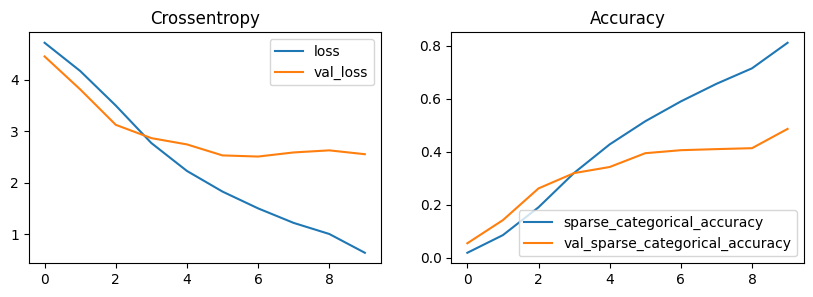

In [27]:
fig, axes = plt.subplots(1, 2)

fig.set_figheight(3)
fig.set_figwidth(10)

# Visualise performance
history_df.loc[:, ["loss", "val_loss"]].plot(title="Crossentropy", ax=axes[0])
history_df.loc[:, ["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot(title="Accuracy", ax=axes[1])

In [28]:
# Define model file
vgg19_file = f"/kaggle/working/{CLASS_NUM}class_vgg19.keras"

# Save model into file for replication purposes
model.save(vgg19_file)

# Conclusions

In a nutshell, results were partially successful.

On the positive side, neural network architectures that are nearly identical to the original VGG models could be designed, trained and validated. Although a smaller dataset was used (roughly 10% of the full set), the data was normalised and processed according to the original pipeline. The great computational demand of the training task was satisfied by executing the current notebook on a TPU, which represents a very relevant skill for deep learning of big data.

On the negative side, low performance was achieved on the development set. Unlike the original models, VGG11 started overfitting as early as 10 epochs, and the deeper ones as soon as training began. Remarkably, training accuracy easily approached 100%, whereas the development one reached a plateau at about 50%. This large divergence in train and devel accuracies might hint to 1). a too complex architecture for the subset of data used or 2). a significant difference between the train and the devel set. While the former is an inevitable consequence of our computational limitations, the latter would originate from improper and differential data preprocessing, which could be easily fixed after a thorough debugging process.

In conclusion, this notebook attempted to replicate the deep learning procedure for computer vision described by [_Simonyan & Zisserman 2015_](https://arxiv.org/pdf/1409.1556v6.pdf), also known as VGG11, VGG13, VGG16 and VGG19 architectures. The dataset was taken from a subset of ImageNet and represented 10% of the entire data. Results were successful with respect to designing and training the models as well as preprocessing data. However, state-of-the-art accuracy could be achieved on the training set but not the devel set, due to a large amount of overfitting which is not in line with the original paper. Overall, the current notebook represented an effort and showed the challenges to replicate a highly performant computer vision architecture.